In [59]:
import pandas as pds

df = pds.read_csv('data/training.raw.csv', sep=';')

def xp_set_rows(df, s):
    return df.xp_set == s

def prepare_df(df):
	df['compute'] = df.benchmark.apply(lambda x : int(x.split('-')[-1]))

	deps_rows = xp_set_rows(df, 'deps')
	
	df.loc[deps_rows, 'write'] = 1
	df.loc[deps_rows, 'read'] = 1

	df.loc[~deps_rows, 'write'] = df[~deps_rows].benchmark.apply(lambda x : int(x.split('-')[-2]))
	df.loc[~deps_rows, 'read'] = df[~deps_rows].benchmark.apply(lambda x : int(x.split('-')[-3]))

	stream_rows = xp_set_rows(df, 'stream')
	membench_rows = xp_set_rows(df, 'membench')
	sm_rows = stream_rows | membench_rows

	df['template'] = 'rcw'

	df.loc[stream_rows, 'template'] = df[stream_rows].benchmark.apply(lambda x : x.split('-')[1])
	df.loc[membench_rows, 'template'] = df[membench_rows].benchmark.apply(lambda x: x.split('-')[-5])
	df['instance'] = df.benchmark.apply(lambda x: '-'.join(x.split('-')[:-1]))
	
	df['throttle'] = df['compute']
	df.loc[sm_rows, 'compute'] = (df[sm_rows].read + df[sm_rows].write) * df[sm_rows].throttle
	df.loc[~sm_rows, 'throttle'] = df[~sm_rows].compute / (df[~sm_rows].read + df[~sm_rows].write) 
        
	df['size_KiB'] = 1024

	df.loc[sm_rows, 'size_KiB'] = df[sm_rows].benchmark.apply(lambda x: int(x.split('-')[-4]))

	df['exceed_cache'] = df.size_KiB > 256
	return df

df = prepare_df(df)

df = df[df.overhead == df.max_overhead]

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 38)

In [6]:
xp_sets = (df.xp_set == 'membench') | (df.xp_set == 'stream')

In [101]:
df[xp_sets][['benchmark', 'template']]

def data_structure(benchmark):
    tokens = benchmark.split('-')
    
    if tokens[0] == 'stream':
        return '2D array'
    if 'lookup' in tokens[0:2]:
        return 'Lookup table'
    if 'list' in tokens[0:2]:
        return 'List'
    return 'Array'

df['Data structure'] = df.benchmark.apply(data_structure)
    
df['l1_bw'] = df.Data_cache_miss / df.total_cycles_iso
df['l1_intensity'] = df.Data_cache_miss / df.Instruction_renamed

df['mildness_pmu'] = df.Instruction_renamed / df.access_mmdc

KeyError: "['access_density_pmu'] not in index"

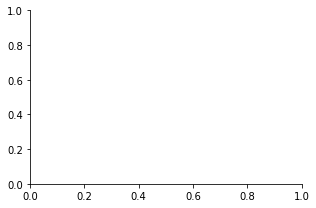

In [105]:
import seaborn as sns

df.throttle += 0.1
g = sns.FacetGrid(data=df[df.xp_set == 'memstress'], col='template', hue='instance', aspect=1.5)

#g.map(sns.scatterplot, 'throttle', 'overhead')
g.map(sns.lineplot, 'l1_intensity', 'access_density_pmu')

g.set(xscale='log', xlabel='$T$', ylabel='Overhead(%)')

/usr/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


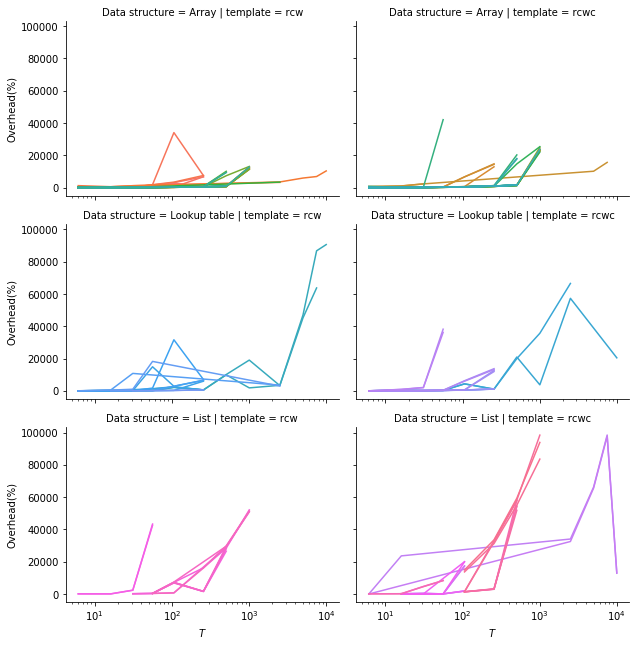

In [100]:
import seaborn as sns

d = df[df.mildness_pmu < 100_000]

d.throttle += 0.1
g = sns.FacetGrid(data=d[(d.xp_set=='membench') & (d.size_KiB == 16384)], col='template', row='Data structure', hue='instance', aspect=1.5)

#g.map(sns.scatterplot, 'throttle', 'overhead')
g.map(sns.lineplot, 'throttle', 'mildness_pmu')

g.set(xscale='log', xlabel='$T$', ylabel='Overhead(%)')

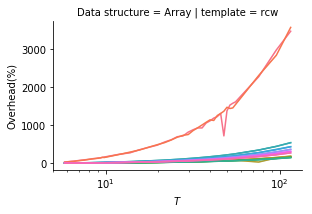

In [96]:
import seaborn as sns

df.throttle += 0.1
g = sns.FacetGrid(data=df[df.xp_set=='memstress'], col='template', row='Data structure', hue='instance', aspect=1.5)

#g.map(sns.scatterplot, 'throttle', 'overhead')
g.map(sns.lineplot, 'throttle', 'mildness_pmu')

g.set(xscale='log', xlabel='$T$', ylabel='Overhead(%)')

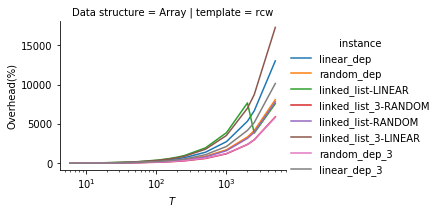

In [97]:
import seaborn as sns

df.throttle += 0.1
g = sns.FacetGrid(data=df[df.xp_set=='deps'], col='template', row='Data structure', hue='instance', aspect=1.5)

#g.map(sns.scatterplot, 'throttle', 'overhead')
g.map(sns.lineplot, 'throttle' ,'mildness_pmu')

g.set(xscale='log', xlabel='$T$', ylabel='Overhead(%)')
g.add_legend()

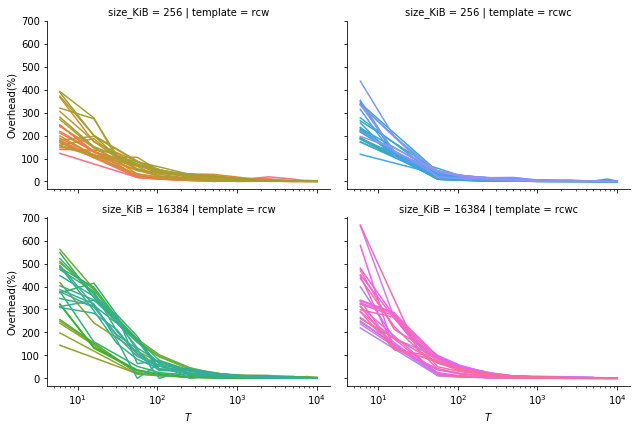

In [98]:
import seaborn as sns

df.throttle += 0.1
g = sns.FacetGrid(data=df[(df.xp_set=='stream')], col='template', row='size_KiB', hue='instance', aspect=1.5)

#g.map(sns.scatterplot, 'throttle', 'overhead')
g.map(sns.lineplot, 'throttle', 'overhead')

g.set(xscale='log', xlabel='$T$', ylabel='Overhead(%)')

In [ ]:
df.l1